In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from utils import *

import numpy as np
import cvxopt

cvxopt.solvers.options['show_progress'] = False

%matplotlib inline

In [4]:
"""
Get the preprocessed data:
X and y are dicts, has keys train, val and test. keys gives you what word (or pair of words) each dimension corresponds to.

You can also get bigram features if you call preprocess(bigram = True)`
Another optional argument mincount specifies the frequency cutoff for inclusion of a word/bigram in the
dictionary.

"""

X, y, keys = preprocess()

Feature size:  1464


In [5]:
class Kernel(object):
    """
    A class containing all kinds of kernels.
    Note: the kernel should work for both input (Matrix, vector) and (vector, vector)
    """
    @staticmethod
    def linear():
        def f(x, y):
            return np.dot(x, y)
        return f

    @staticmethod
    def gaussian(gamma):  # we use the commonly used name, although it's not really a Gaussian
        def f(x, y):
            exponent = - gamma * np.linalg.norm((x-y).transpose(), 2, 0) ** 2
            return np.exp(exponent)
        return f

    @staticmethod
    def _poly(dimension, offset):
        def f(x, y):
            return (offset + np.dot(x, y)) ** dimension
        return f

    @staticmethod
    def inhomogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=1.0)

    @staticmethod
    def homogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=0.0)

    @staticmethod
    def hyperbolic_tangent(kappa, c):
        def f(x, y):
            return np.tanh(kappa * np.dot(x, y) + c)
        return f

In [6]:
class SVM(object):
    def __init__(self, kernel, c):
        """
        Build a SVM given kernel function and C

        Parameters
        ----------
        kernel : function
            a function takes input (Matrix, vector) or (vector, vector)
        c : a scalar
            balance term

        Returns
        -------
        """
        self._kernel = kernel
        self._c = c

    def fit(self, X, y):
        """
        Fit the model given data X and ground truth label y

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        -------
        """
        # Solve the QP problem to get the multipliers
        lagrange_multipliers = self._compute_multipliers(X, y)
        # Get all the support vectors, support weights and bias
        return self._construct_predictor(X, y, lagrange_multipliers)
    
    def predict(self, X):

        result = np.full(X.shape[0], self._bias) # allocate
        alp = self._weights
        supportvecs = self._support_vectors
        supportlabels = self._support_vector_labels
        for ind_i,val_xi in enumerate(X):
            for ind_j, val_xj in enumerate(supportvecs):
                result[ind_i] = result[ind_i] + alp[ind_j]*supportlabels[ind_j]*self._kernel(val_xi,val_xj)
        
        return np.sign(result)

    def _kernel_matrix(self, X):
        """
        Get the kernel matrix.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        K : 2D array
            N x N kernel matrix
        """
        N, d = X.shape
        K = np.zeros((N, N))
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
        return K

    def _construct_predictor(self, X, y, lagrange_multipliers):
        """
        Given the data, label and the multipliers, extract the support vectors and calculate the bias

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label
        lagrange_multipliers: 1D array
            the solution of lagrange_multiplier

        Fills in relevant variables: model bias and weights (alphas), and details of support vectors
        
        -------
        """
        support_vector_indices = \
            lagrange_multipliers > 1e-5
            
        print("SV number: ", np.sum(support_vector_indices))

        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]

        """
        Get the bias term (w_0)
        """
        bias = np.sum(support_vector_labels)
        for i, x_i in enumerate(support_vectors):
            for j,x_j in enumerate(support_vectors):
                bias = bias - support_multipliers[j]*support_vector_labels[j]*self._kernel(x_i,x_j)
        bias = bias / float(np.sum(support_vector_indices))
        
        self._bias=bias
        self._weights=support_multipliers
        self._support_vectors=support_vectors
        self._support_vector_labels=support_vector_labels
        
        
    def _compute_multipliers(self, X, y):
        """
        Given the data, label, solve the QP program to get lagrange multiplier.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        lagrange_multipliers: 1D array
        -------
        """
        N, d = X.shape

        K = self._kernel_matrix(X)
        """
        The standard QP solver formulation:
        min 1/2 x^T H x + f^T x
        s.t.
        Ax <=  a
        Bx = b
        """
        H = cvxopt.matrix(np.outer(y,y)*K)
        f = cvxopt.matrix(-1 * np.ones(N))

        A = cvxopt.matrix(np.vstack((cvxopt.matrix(np.diag(np.ones(N))), cvxopt.matrix(np.diag(np.ones(N) * -1)))))
        a = cvxopt.matrix(np.vstack((cvxopt.matrix(np.ones(N) * self._c), cvxopt.matrix(np.zeros(N)))))

        B = cvxopt.matrix(y, (1, N))
        b = cvxopt.matrix(0.0)
        
        # call the QP solver
        solution = cvxopt.solvers.qp(H, f, A, a, B, b)

        # Lagrange multipliers (the unknown vector 'x' is our alphas)
        return np.ravel(solution['x'])

Test the trainer.
The following code would generate data which the grounth truth split is x+y = 0.5.

SV number:  8


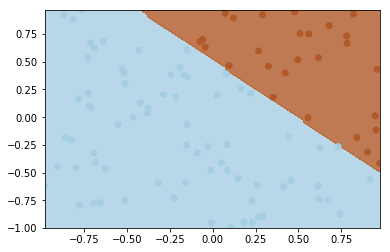

In [7]:
clf = SVM(Kernel.linear(), 100)
test_linear_SVM(clf, 100)

SV number:  12


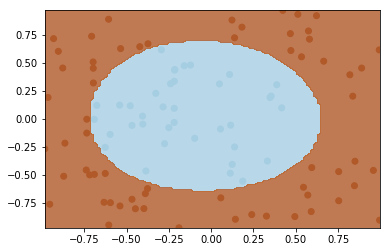

In [8]:
clf = SVM(Kernel.gaussian(1), 100)
test_rbf_SVM(clf, 100)

If you think your code is correct, then we can move to the real problem. Below are some code examples; you will need to fill in some details, and extend these to any experiments you want to run.

In [9]:
 for C in [1,2,3,4]:
    clf = SVM(Kernel.linear(), C)
    clf.fit(X['train'], y['train'].astype('double'))
    print("C = ", C)
    y_hat = clf.predict(X['train'])
    print("Acc on train: ", np.mean(y_hat == y['train']))
    y_hat = clf.predict(X['val'])
    print("Acc on val: ", np.mean(y_hat == y['val']))

SV number:  1268
C =  1
Acc on train:  0.956036036036
Acc on val:  0.724
SV number:  1165
C =  2
Acc on train:  0.97045045045
Acc on val:  0.746
SV number:  1139
C =  3
Acc on train:  0.980540540541
Acc on val:  0.732
SV number:  1107
C =  4
Acc on train:  0.984864864865
Acc on val:  0.734


Choose the best C, and predict the label for test data.

In [17]:
C = 2
clf = SVM(Kernel.linear(), C)
clf.fit(X['train'], y['train'].astype('double'))
y_hat = clf.predict(X['test'])
save_submission('sub_linear.csv', y_hat)


SV number:  1165


RBF (Gaussian) kernel SVM

In [13]:
for C in [1,2,3,4]:
    for gamma in [0.0001,0.01,1,10]:
        clf = SVM(Kernel.gaussian(gamma), C)
        clf.fit(X['train'], y['train'].astype('double'))
        print("C = ", C)
        print("gamma = ", gamma)
        y_hat = clf.predict(X['train'])
        print("Acc on train: ", np.mean(y_hat == y['train']))
        y_hat = clf.predict(X['val'])
        print("Acc on val: ", np.mean(y_hat == y['val']))
        

SV number:  2246
C =  1
gamma =  0.0001
Acc on train:  0.636396396396
Acc on val:  0.67
SV number:  2064
C =  1
gamma =  0.01
Acc on train:  0.83027027027
Acc on val:  0.722
SV number:  2775
C =  1
gamma =  1
Acc on train:  1.0
Acc on val:  0.67
SV number:  2775
C =  1
gamma =  10
Acc on train:  1.0
Acc on val:  0.67
SV number:  2480
C =  2
gamma =  0.0001
Acc on train:  0.636396396396
Acc on val:  0.67
SV number:  1925
C =  2
gamma =  0.01
Acc on train:  0.864864864865
Acc on val:  0.746
SV number:  2775
C =  2
gamma =  1
Acc on train:  1.0
Acc on val:  0.67
SV number:  2775
C =  2
gamma =  10
Acc on train:  1.0
Acc on val:  0.67
SV number:  2688
C =  3
gamma =  0.0001
Acc on train:  0.636396396396
Acc on val:  0.67
SV number:  1889
C =  3
gamma =  0.01
Acc on train:  0.887207207207
Acc on val:  0.75
SV number:  2775
C =  3
gamma =  1
Acc on train:  1.0
Acc on val:  0.67
SV number:  2775
C =  3
gamma =  10
Acc on train:  1.0
Acc on val:  0.67
SV number:  2713
C =  4
gamma =  0.0001
Ac

In [16]:
clf = SVM(Kernel.gaussian(0.01), 3)
clf.fit(X['train'], y['train'].astype('double'))
y_hat = clf.predict(X['test'])
save_submission('sub_rbf.csv', y_hat)


SV number:  1889


In [ ]:
Since gamma is proportional to the inverse of the variance, as its value increases
we see that the model starts to overfit since it has a small variance and the train accuracy approaches 1. 
This happens to all different values of C for gamma greater or equal to 1. Once we allow the variance to be greater, 
i.e, smaller gamas, we arrive at the best estimator at gamma=0.01. 
For the regularization parameter C we have a optimal value at C=3,
but when looking at the range of values for C maintaining gamma=0.01 there is no substantial change. The training acc
does increase with the increase of C, though. 